## Семинар 15: "Обучение с подкреплением 2"

ФИО: Иванов Максим Юрьевич


###  FrozenLake


<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>



In [ ]:
import gym
import numpy as np 
import random

#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

In [ ]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

## Задание 1.
Подберите значения alpha и epsilon и найдите приближение оптимальной Q-функции для Frozen Lake.

In [ ]:
class QLearn:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        oldv = self.q.get((state, action), None)

        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def chooseAction(self, state):
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.getQ(state, a) for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma*maxqnew)

In [ ]:
qlearn = QLearn(actions=range(env.env.nA), gamma=1, epsilon=0.1, alpha=0.2)

In [ ]:
def run_episode_qlearn_learn(env, qlearn, gamma = 1.0, render = False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        qlearn.learn(obs, action, reward, obs_new)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [ ]:
def run_episode_qlearn(env, qlearn, gamma=1.0, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [ ]:
def evaluate_qlearn(env, qlearn, gamma=1.0,  n=100):
    scores = [
            run_episode_qlearn(env, qlearn, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

In [ ]:
from itertools import product
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
n = 1000

best_alpha = 0
best_eps = 0
best_reward = 0

params = product(
    np.linspace(0, 1, 11), np.linspace(0, 1, 11)
)

for alpha, eps in tqdm(params):
    qlearn = QLearn(actions = range(env.env.nA), epsilon=eps, alpha=alpha)
    for i in range(n):
        run_episode_qlearn(env, qlearn)
    avg_reward = evaluate_qlearn(env, qlearn, n=n)
    if avg_reward > best_reward:
        best_alpha, best_eps = alpha, eps
        best_reward = avg_reward

print(f'Alpha: {best_alpha}, Epsilon: {best_eps}, Reward: {best_reward}')


Alpha: 0.5, Epsilon: 0.5, Reward: 0.026


## Задание 2.
Обучите сеть DQN для среды http://gym.openai.com/envs/Pong-v0/ 

In [1]:
import torch
import gym
import random
import time
import numpy as np
from torch import nn, optim

from collections import namedtuple
from itertools import count
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
env = gym.make('Pong-v0')
env.reset();

In [3]:
def get_screen(env):
    screen = env.render(mode='rgb_array')
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return screen

def plot_screen(screen=None, env=None):
    screen = screen or get_screen(env)
    plt.figure(figsize=(5,8))
    plt.imshow(screen.cpu().squeeze(0).numpy(),
            interpolation='none')
    plt.show()

In [142]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [143]:
class DQN(nn.Module):
    def __init__(self, in_channels=3, n_actions=6):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.linear = nn.Sequential(
            nn.Linear(32 * 27 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
        
    def forward(self, x):
        bs = x.shape[0] // 210
        x = x.reshape((bs, 3, 210, 160))
        x = self.conv(x)
        x = x.reshape(x.size(0), 32 * 27 * 16)
        return self.linear(x)

In [193]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
    
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = reward_batch
    expected_state_action_values[non_final_mask] = ((next_state_values[non_final_mask] * GAMMA) + reward_batch[non_final_mask])
    
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [194]:
def select_action(state, action_count=6):
    global steps_done
    eps = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if eps > eps_threshold:
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(action_count)]], device=device)

In [195]:
def train(env, n_episodes=10, target_update=10):
    global ep_start
    printed = ''
    for episode in tqdm(range(ep_start, n_episodes)):
        env.reset()
        prev_screen = get_screen(env=env)
        screen = get_screen(env=env)
        state = screen - prev_screen

        total_reward = 0.0
        for t in count():
            action = select_action(state)

            obs, reward, done, _ = env.step(action)
            total_reward += reward
            reward = torch.tensor([reward], device=device)

            screen, prev_screen = get_screen(env=env), screen
            next_state = screen - prev_screen

            if done:
                next_state = None

            memory.push(state, action.to('cpu'), reward.to('cpu'), next_state)
            state = next_state

            optimize_model()

            if done:
                break
        
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        ep_start += 1
        
        text = f'Steps: {steps_done} \t Episode: {episode}/{n_episodes} \t t = {t} \t Total reward: {total_reward}'
        printed += text + '\n'
        print(text)
    env.close()
    return

In [196]:
BATCH_SIZE = 64
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 1000
lr = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN().to(device) # активно обучаемая сеть
target_net = DQN().to(device) # ее копия, создаваемая для того, чтобы зафиксировать веса
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters(), lr=lr)
criterion = nn.functional.smooth_l1_loss

steps_done = 0

memory = ReplayMemory(10000)

env = gym.make('Pong-v0')
env.reset();
ep_start = 0

In [197]:
%%time
print(device)
train(env, 10)

cuda


Steps: 1098 	 Episode: 0/10 	 t = 1097 	 Total reward: -21.0
Steps: 2375 	 Episode: 1/10 	 t = 1276 	 Total reward: -19.0
Steps: 3376 	 Episode: 2/10 	 t = 1000 	 Total reward: -21.0
Steps: 4563 	 Episode: 3/10 	 t = 1186 	 Total reward: -21.0
Steps: 5622 	 Episode: 4/10 	 t = 1058 	 Total reward: -21.0
Steps: 6788 	 Episode: 5/10 	 t = 1165 	 Total reward: -20.0
Steps: 8173 	 Episode: 6/10 	 t = 1384 	 Total reward: -21.0
Steps: 9493 	 Episode: 7/10 	 t = 1319 	 Total reward: -21.0
Steps: 10713 	 Episode: 8/10 	 t = 1219 	 Total reward: -21.0
Steps: 11964 	 Episode: 9/10 	 t = 1250 	 Total reward: -20.0

CPU times: user 6min 14s, sys: 5.67 s, total: 6min 20s
Wall time: 6min 18s


In [198]:
def test(env, policy, n_episodes=1, plot_game=True):
    printed = ''
    for episode in range(n_episodes):
        env.reset()
        prev_screen = get_screen(env=env)
        screen = get_screen(env=env)
        state = screen - prev_screen
        total_reward = 0.0
        for _ in count():
            action = policy(state.to(device)).max(1)[1].view(1,1)

            if plot_game:
                clear_output(True)
                if printed:
                    print(printed)
                plot_screen(env=env)
                time.sleep(0.02)

            obs, reward, done, _ = env.step(action)
            total_reward += reward

            screen, prev_screen = get_screen(env=env), screen
            next_state = screen - prev_screen

            if done:
                next_state = None

            state = next_state

            if done:
                text = "Finished Episode {} with reward {}".format(episode, total_reward)
                printed += text
                print(text)
                break

    env.close()
    return

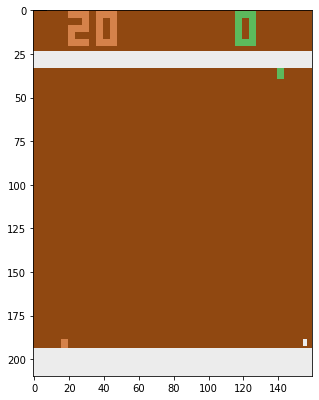

Finished Episode 0 with reward -21.0


In [199]:
test(env, policy_net)

Кажется, для нормального обучения требуется больше итераций и подбор гиперпараметров, но с учетом того, сколько времени считается одна игра - вряд ли я успею это сделать.